# BERT

BERT stands for **Bidirectional Encoder Representations from Transformers**

- **Encoder Representations**: BERT is a language modeling system that is trained with unlabeled data, in a semi-supervised way, it gives the most efficient and the most flexible representation for words and sequences. Then fine-tuning 
- **From Transformer**: It's a powerful NLP algorithm that was designed to tackle many sequences to sequences tasks like: translator or chatbot. It defines the archtecture of BERT,  developed by Google.
- **Bidirectional**: to predict the next word in our sentence, we usually whould have access to  the left part of the sentence or the right part of the sentence or the left part and the right part separately the concatenate both $\to$ pseudo bidirectional. But with BERT, it has access to the whole sentence. To not cheat (copying and pasting the word) we use *masked language model*.

### Bert models of Google

L: Number of encoder layers

H: Hidden size (Embedding dim)

A: Number of self-attention heads

Bert_base: L=12, H=768, A=12, parameters=110M

Bert_large: L=24, H=1024, A=16, parameters=340M

# Word representation

1. One-Hot-Encoding:
- Very easy representation
- Ineffective represention
- Sparse vectors
- No relation between words
- All the words are independent of each other



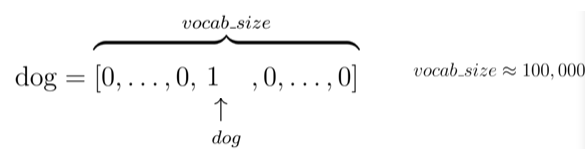

2. Word Embedding
- Effective representation
- Dense vector (smaller vectors, in a certain way, we add more constraints to our information, it has less liberty and that forces our system to create relations)
- Mathematical operations between words

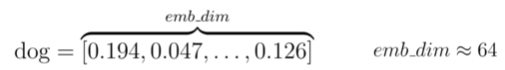


**Word2Vec** is a method to construct such an *embedding*. It can be obtained using two methods (both involving Neural Networks): Skip Gram and Common/Continuous Bag Of Words (CBOW)

> Close meaning $\to$ Similar context $\to$ Occupies close spatial positions $\to$ Cosine(Angle(W_1, W_2) ~ 1 & Angle ~ 0 $\to$ Close embedding

# Transfer Learning in NLP

+ ELMo
    - Pseudo bidirectional, it has access to the left context and the right contect separately, then
    - Uses RNNs or LSTMs (sequential model)
    - Loss information if we have long sentences (RNN + LSTM)
    - We don't have access to all words at once, in the same way, to give the same importance to each word. We don't want the architecture to decide for us, which would have more importance.


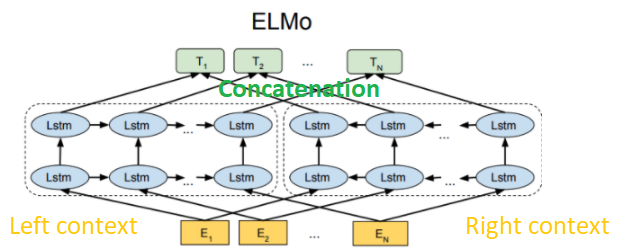

# OpenIA GPT 

- Uses transformers
- Not bidirectional
- Each word has equal access to all the other words, and everything is mixed together in a clever and efficient way to have a great representation of the words and of the sentence.
- For training purposes, we can't allow the information to go everywhere. We put START token to shift the sentence.
- We have access to the left part

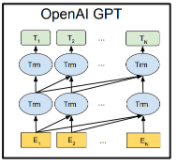

## Tasks 

- Not suitable for the moment for standard sequence to sequence tasks: translator, chatbot...
- Suitable for :
    + text classification
    + retrieve the appropriate sentence in a paragraph that answers your question (BERT takes the query and the conxtext, then finds the answer of the query in the context - we have 2 classifiers)

    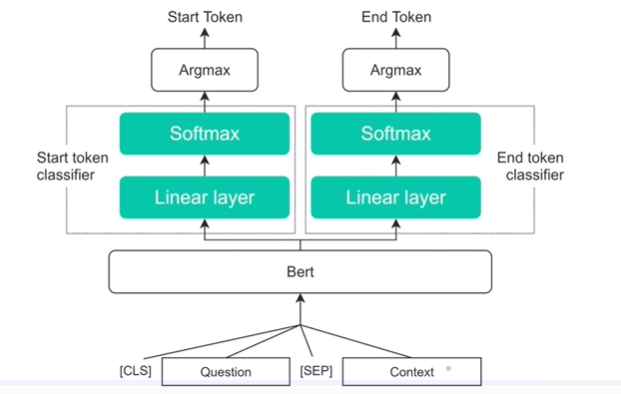
    + get the meaning of sentences
    + questioning answering, Masked language modeling (mask one word, let BERT guess the missing word).

## Motivation of the attention mecanism

Previously, with the sequential encoder and RNN, if the input is too long, we will loss the information of the beginning of the sentence.



During the decoding phase, we add a new input to our cells called the *context vector*. The **context vector** uses all the input sequence (weighted sum of all hidden states from the encoder) and conveys a global information about the input.

This improves the decoding phase. 

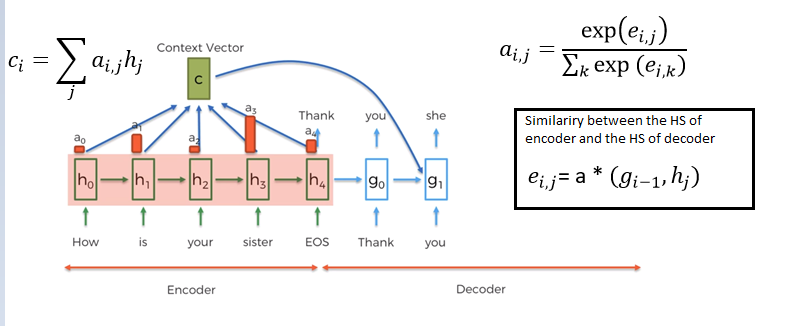

### Bert's Input 

[CLS] + Sentence A + [SEPT] + Sentence B

[CLS]: classification token

[SEP]: Sparation token between 2 sentences (sentence B is optional)


### What shape for sentences?

String $\to (Tokenization) \to$ Tokens $\to (Embedding) \to$ Vectors

He likes playing $\to$ [He, likes, play, ##ing] $\to$ [[XX, ...


### BERT's Tokenizer:

WordPiece tokenizer
- 30522 words
- Deals with a new word be combining known words
- Trade off between vocab size and out-of-vocab word

bad example: 

I love covfefe $\to$ I, love, co, ##v, ##fe, ##fe

> Transformer: self-attention + multi-head attention + Positional Encoding

##Self-attention

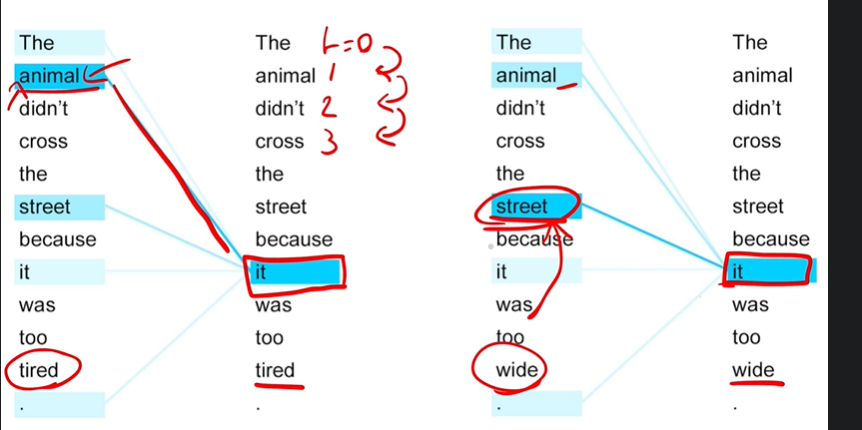

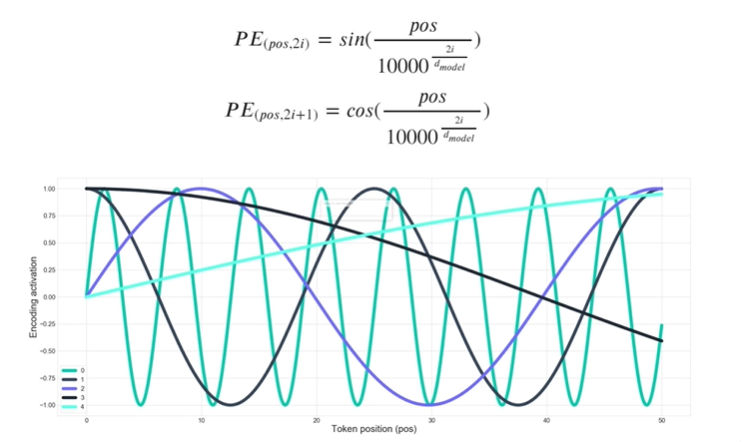

In [ ]:
# Libraries 

import numpy as np

import tensorflow as tf

# https://www.youtube.com/watch?v=mWA-PmxMBDk&t=1483s
# https://colab.research.google.com/drive/1akAsUAddF2-x57BJBA_gF-v4htyiR12y?usp=sharing#scrollTo=CEiTxF7yMsLk

### Reminder - Create a Model in Tf.Keras

```python
inputs  = tf.keras.Input(shape=(3,))
x       = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
model   = tf.keras.Model(inputs=inputs, outputs=outputs)
```

or 

```python
class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.dense1(inputs)
    return self.dense2(x)

model = MyModel()
```

# 1. Simple data 

In [ ]:
input_embedding = [[  "Salut", "comment", "ca", "va", "?"]
                   ] # input_embedding.shape -> batch size, len seq

# Traduit la phrase sachant les tokens que j'ai donné
# On ajoute un mask
# Pour cacher les prochains tokens, pour qu'il ne fasse pas de copier coller
output_embedding = [["<START>", "Hi", "how", "are", "you", "?"]
                    ] # output_embedding.shape -> batch size, len seq

# 2. Naive preprocessing 

1. Define the vocabulary: for each token, we will assign an ID
2. Naive word to vector: Convert each word to a number 
3. Vecto to embedding with TF


In [ ]:
############### 1. Define the vocabulary: for each token, we will assign an ID

def get_vocabulary(sequences):

    token_to_info = {}

    for sequence in sequences:
        for word in sequence:
            if word not in token_to_info:
                 # We will take the current length as an Id
                token_to_info[word] = len(token_to_info)

    # Add default tokens for BERT
    if '<START>' not in token_to_info: 
        token_to_info["<START>"] = len(token_to_info)
    token_to_info["<END>"] = len(token_to_info)
    token_to_info["<PAD>"] = len(token_to_info)

    return token_to_info

input_voc  = get_vocabulary(input_embedding)
output_voc = get_vocabulary(output_embedding)

print(f"Define the vocab:")
print(f"input: {input_voc}")
print(f"output: {output_voc}\n")

############### 2. Naive word to vector: Convert each word to a number 

def sequences_to_int(sequences, voc):
    return np.array([[voc[word] for word in sentence] for sentence in sequences])

input_seq  = sequences_to_int(input_embedding, input_voc)
output_seq = sequences_to_int(output_embedding, output_voc)

print(f"Convert each word to a number:")
print(f"input_seq: {input_seq}   - Shape: {input_seq.shape} - Type: {type(input_seq)}")
print(f"input_seq: {output_seq} - Shape: {output_seq.shape} - Type: {type(output_seq)}")

Define the vocab:
input: {'Salut': 0, 'comment': 1, 'ca': 2, 'va': 3, '?': 4, '<START>': 5, '<END>': 6, '<PAD>': 7}
output: {'<START>': 0, 'Hi': 1, 'how': 2, 'are': 3, 'you': 4, '?': 5, '<END>': 6, '<PAD>': 7}

Convert each word to a number:
input_seq: [[0 1 2 3 4]]   - Shape: (1, 5) - Type: <class 'numpy.ndarray'>
input_seq: [[0 1 2 3 4 5]] - Shape: (1, 6) - Type: <class 'numpy.ndarray'>


In [ ]:
############### 3. Vecto to embedding 

class EmbeddingLayer(tf.keras.layers.Layer):
    # nb_token = vocab_size
  def __init__(self, nb_token, size_embedding=256, **kwargs):
    self.nb_token = nb_token
    self.size_embedding = size_embedding
    super(**kwargs).__init__()
  
  def build(self, input_shape):
    self.word_embedding = tf.keras.layers.Embedding(
        self.nb_token, self.size_embedding)
    super().build(input_shape)
  
  def call(self, x):
    embed = self.word_embedding(x)
    return embed

# Test 
batch_size, size_seq, size_embedding = None, 5, 256

input_layer = tf.keras.Input(shape=(size_seq), batch_size=batch_size, name=None, 
                             dtype=None, sparse=None, tensor=None,
                             ragged=None, type_spec=None)
"""
tf.Keras.input : is used to instantiate a Keras tensor (i.e. a placeholder) to allow us to build a Keras model
For instance, if a, b and c are Keras tensors, it becomes possible to do: model = Model(input=[a, b], output=c)
Shape: A shape tuple (integers)
For instance, shape=(32,) or (None, 32) indicates that the expected input will be batches of 32-dimensional vectors.
Elements of this tuple can be None; 'None' elements represent dimensions where the shape is not known.
"""
emb_layer = EmbeddingLayer(nb_token=size_seq)(input_layer)
emb_layer

<KerasTensor: shape=(None, 5, 256) dtype=float32 (created by layer 'embedding_layer')>

# 3. Multi-Head-Attention

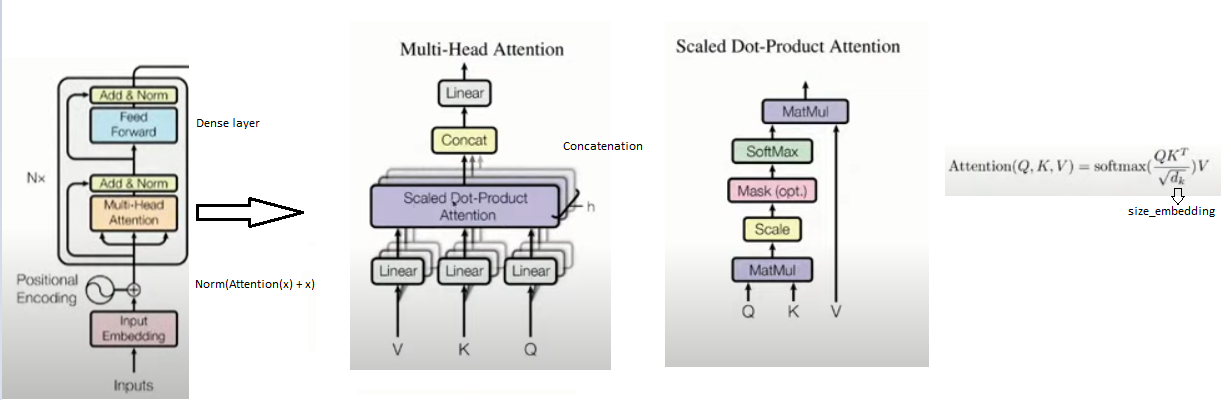

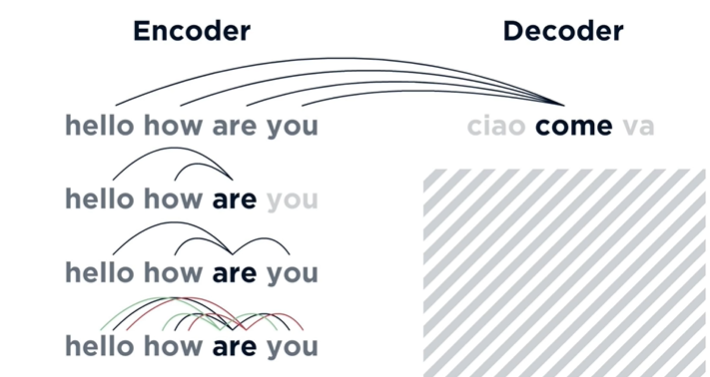

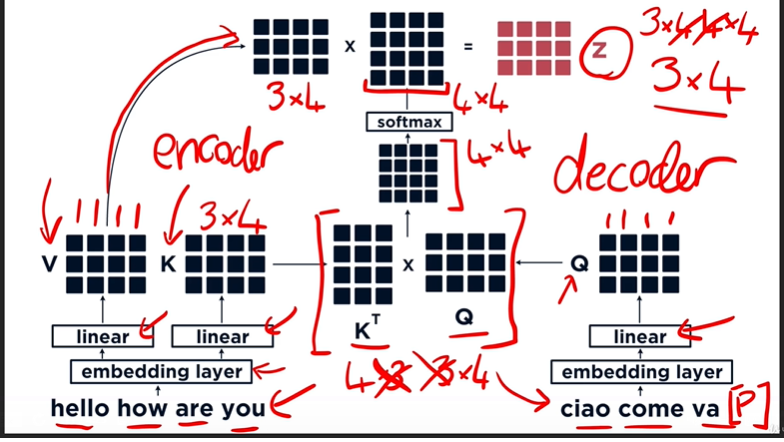

## 3.1 ScaledDotProductAttention

In [ ]:
# 3.1 ScaledDotProductAttention without mask  

class ScaledDotProductAttention(tf.keras.layers.Layer):

  def __init__(self, size_embedding=256, **kwargs):
    self.size_embedding = size_embedding
    super(**kwargs).__init__()
    
  def build(self, input_shape):  
    self.query_layer = tf.keras.layers.Dense(self.size_embedding)
    self.value_layer = tf.keras.layers.Dense(self.size_embedding)
    self.key_layer   = tf.keras.layers.Dense(self.size_embedding)  
    super().build(input_shape)
  
  def call(self, x):
    Q  = self.query_layer(x)
    K  = self.key_layer(x)
    V  = self.value_layer(x)
    QK = tf.matmul(Q, K, transpose_b=True)                   # Shape: (batch_size=1, size_seq=5, size_seq=5)
    # Normalization
    QK = QK / tf.math.sqrt(np.float32(self.size_embedding))  # Shape: (batch_size=1, size_seq=5, size_seq=5)
    # The information that we can take from the dot product
    softmax_QK = tf.nn.softmax(QK, axis=-1)                  # Shape: (batch_size=1, size_seq=5, size_seq=5)
    attention  = tf.matmul(softmax_QK, V)                    # Shape: (batch_size=1, size_seq=5, size_embedding=5)
    return attention

# Test 
batch_size, size_seq, size_embedding = None, 5, 256

input_layer = tf.keras.Input(shape=(size_seq,))
emb_layer   = EmbeddingLayer(nb_token=size_seq)(input_layer)
attention   = ScaledDotProductAttention()(emb_layer)
model       = tf.keras.Model(input_layer, attention)

model.summary()
model(input_seq).shape

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
embedding_layer_1 (Embedding (None, 5, 256)            1280      
_________________________________________________________________
scaled_dot_product_attention (None, 5, 256)            197376    
Total params: 198,656
Trainable params: 198,656
Non-trainable params: 0
_________________________________________________________________


TensorShape([1, 5, 256])

## 3.2 MultiHeadAttention

In [ ]:
# 3.2 MultiHeadAttention without mask 

class MultiHeadAttentionWithoutMask(tf.keras.layers.Layer):
    # Set of ScaledDotProductAttention

  def __init__(self, dim=256, nb_head=8, **kwargs):
    # <!> dim should be divisible by nb_head
    self.dim      = dim
    self.head_dim = 256 // 8 # Each head will work on a vecteur of size 256 // 8 = 32
    self.nb_head  = nb_head
    super(**kwargs).__init__()
  
  def build(self, input_shape):
    self.query_layer = tf.keras.layers.Dense(256)
    self.value_layer = tf.keras.layers.Dense(256)
    self.key_layer   = tf.keras.layers.Dense(256)
    self.out_proj = tf.keras.layers.Dense(256)
    # We will then decompose these vectors according to the size of the head-attentions
    super().build(input_shape)

  def call(self, x, mask=None):
    # Bloc 1: Get Query, Key, Value in the right shape 
    Q  = self.query_layer(x) # Shape: (1, 5, 256)
    K  = self.key_layer(x)   # Shape: (1, 5, 256)
    V  = self.value_layer(x) # Shape: (1, 5, 256)
    # 1.1 Decompose these vectors according to the size of the head-attentions
    batch_size = tf.shape(Q)[0]
    Q_seq_len, K_seq_len, V_seq_len = tf.shape(Q)[1], tf.shape(K)[1], tf.shape(V)[1]

    Q = tf.reshape(Q, [batch_size, Q_seq_len, self.nb_head, self.head_dim]) # Shape: (batch_size=1, size_len=5, nb_head=8, head_dim=32) 
    K = tf.reshape(K, [batch_size, K_seq_len, self.nb_head, self.head_dim]) # Shape: (batch_size=1, size_len=5, nb_head=8, head_dim=32) 
    V = tf.reshape(V, [batch_size, V_seq_len, self.nb_head, self.head_dim]) # Shape: (batch_size=1, size_len=5, nb_head=8, head_dim=32) 
    
    # 1.2 Ensure that operations can be carried out in parallel
    # Make the calculation the heads independant
    Q = tf.transpose(Q, [0, 2, 1, 3]) # Shape: (batch_size=1, nb_head=8, nb_head=5, head_dim=32) 
    K = tf.transpose(K, [0, 2, 1, 3]) # Shape: (batch_size=1, nb_head=8, nb_head=5, head_dim=32) 
    V = tf.transpose(V, [0, 2, 1, 3]) # Shape: (batch_size=1, nb_head=8, nb_head=5, head_dim=32) 
    # 1.3 Put the head in the batch dim 
    Q = tf.reshape(Q, [batch_size * self.nb_head, Q_seq_len, self.head_dim]) # Shape: (batch_size=8, nb_head=5, head_dim=32)
    K = tf.reshape(K, [batch_size * self.nb_head, K_seq_len, self.head_dim]) # Shape: (batch_size=8, nb_head=5, head_dim=32)
    V = tf.reshape(V, [batch_size * self.nb_head, V_seq_len, self.head_dim]) # Shape: (batch_size=8, nb_head=5, head_dim=32)
   
    # Bloc 2: ScaledDotProductAttention
    QK = tf.matmul(Q, K, transpose_b=True) # Shape: (batch_size=8, size_seq=5, size_seq=5)
    # 2.1 Normalization
    QK = QK / tf.math.sqrt(np.float32(self.dim))  # Shape: (batch_size=8, size_seq=5, size_seq=5)
    # 2.3 The information that we can take from the dot product
    softmax_QK = tf.nn.softmax(QK, axis=-1)  # Shape: (batch_size=8, size_seq=5, size_seq=5)
    # 2.4 
    attention  = tf.matmul(softmax_QK, V)    # Shape: (batch_size=8, size_seq=5, size_embedding=256)   
    # 2. 3 Concat
    attention = tf.reshape(attention, [batch_size, self.nb_head, Q_seq_len, self.head_dim])
    attention = tf.transpose(attention, [0, 2, 1, 3])
    attention = tf.reshape(attention, [batch_size, Q_seq_len, self.nb_head * self.head_dim])
    # 2.4 Linear
    out_attention = self.out_proj(attention) # Shape: (batch_size=8, size_seq=5, size_embedding=256)  
    return out_attention

# Test 
batch_size, size_seq, size_embedding = None, 5, 256

input_layer = tf.keras.Input(shape=(size_seq,))
emb_layer   = EmbeddingLayer(nb_token=size_seq)(input_layer)
attentions  = MultiHeadAttentionWithoutMask()(emb_layer)
model       = tf.keras.Model(input_layer, attentions)

model.summary()
model(input_seq).shape

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
embedding_layer_2 (Embedding (None, 5, 256)            1280      
_________________________________________________________________
multi_head_attention_without (None, None, 256)         263168    
Total params: 264,448
Trainable params: 264,448
Non-trainable params: 0
_________________________________________________________________


TensorShape([1, 5, 256])

In [ ]:
# 3.2 MultiHeadAttention with mask

class MultiHeadAttentionWithMask(tf.keras.layers.Layer):
    # Set of ScaledDotProductAttention

  def __init__(self, dim=256, nb_head=8, **kwargs):
    # <!> dim should be divisible by nb_head
    self.dim      = dim
    self.head_dim = 256 // 8 # Each head will work on a vecteur of size 256 // 8 = 32
    self.nb_head  = nb_head
    super(**kwargs).__init__()
  
  def build(self, input_shape):
    self.query_layer = tf.keras.layers.Dense(256)
    self.value_layer = tf.keras.layers.Dense(256)
    self.key_layer   = tf.keras.layers.Dense(256)
    self.out_proj    = tf.keras.layers.Dense(256)
    # We will then decompose these vectors according to the size of the head-attentions
    super().build(input_shape)

    # Why ?
    # We don't want to consider the 0 values of the mask in the Softmax
    # Replace 0 by -inf
  def mask_softmax(self, x, mask):
      # X ->  Shape: (batch_size=8, size_seq=5, size_seq=5)
      # Mask ->  Shape: (batch_size=1, size_seq=5, size_seq=5)
    x_expe = tf.math.exp(x)  # Shape: (batch_size=8, size_seq=5, size_seq=5)
    x_expe_masked = x_expe * mask
    x_expe_sum = tf.reduce_sum(x_expe_masked, axis=-1) # Shape: (batch_size=8, size_seq=5)  
    x_expe_sum = tf.expand_dims(x_expe_sum, axis=-1)   # Shape: (batch_size=8, size_seq=5, 1)  
    softmax = x_expe_masked / x_expe_sum
    return softmax


  def call(self, x, mask=None):

    in_query, in_key, in_value = x
    # Bloc 1: Get Query, Key, Value in the right shape 
    Q  = self.query_layer(in_query) # Shape: (1, 5, 256)
    K  = self.key_layer(in_key)   # Shape: (1, 5, 256)
    V  = self.value_layer(in_value) # Shape: (1, 5, 256)
    # 1.1 Decompose these vectors according to the size of the head-attentions
    batch_size = tf.shape(Q)[0]
    Q_seq_len, K_seq_len, V_seq_len = tf.shape(Q)[1], tf.shape(K)[1], tf.shape(V)[1]

    Q = tf.reshape(Q, [batch_size, Q_seq_len, self.nb_head, self.head_dim]) # Shape: (batch_size=1, size_len=5, nb_head=8, head_dim=32) 
    K = tf.reshape(K, [batch_size, K_seq_len, self.nb_head, self.head_dim]) # Shape: (batch_size=1, size_len=5, nb_head=8, head_dim=32) 
    V = tf.reshape(V, [batch_size, V_seq_len, self.nb_head, self.head_dim]) # Shape: (batch_size=1, size_len=5, nb_head=8, head_dim=32) 
    
    # 1.2 Ensure that operations can be carried out in parallel
    # Make the calculation the heads independant
    Q = tf.transpose(Q, [0, 2, 1, 3]) # Shape: (batch_size=1, nb_head=8, nb_head=5, head_dim=32) 
    K = tf.transpose(K, [0, 2, 1, 3]) # Shape: (batch_size=1, nb_head=8, nb_head=5, head_dim=32) 
    V = tf.transpose(V, [0, 2, 1, 3]) # Shape: (batch_size=1, nb_head=8, nb_head=5, head_dim=32) 
    # 1.3 Put the head in the batch dim 
    Q = tf.reshape(Q, [batch_size * self.nb_head, Q_seq_len, self.head_dim]) # Shape: (batch_size=8, nb_head=5, head_dim=32)
    K = tf.reshape(K, [batch_size * self.nb_head, K_seq_len, self.head_dim]) # Shape: (batch_size=8, nb_head=5, head_dim=32)
    V = tf.reshape(V, [batch_size * self.nb_head, V_seq_len, self.head_dim]) # Shape: (batch_size=8, nb_head=5, head_dim=32)
   
    # Bloc 2: ScaledDotProductAttention
    QK = tf.matmul(Q, K, transpose_b=True) # Shape: (batch_size=8, size_seq=5, size_seq=5)
    # 2.1 Normalization
    QK = QK / tf.math.sqrt(np.float32(self.dim))  # Shape: (batch_size=8, size_seq=5, size_seq=5) 5 by 5: self_attention

    # Bloc 3: Mask
    # Multiply by 0, the value that we want to hide
    # For instance, for a givin output size of 6:
    # [1, 0, 0, 0, 0, 0] -> The first element of the seq, it can access inly to itself
    # [1, 1, 0, 0, 0, 0] -> The second element of the seq, it can access inly to itself and the previous token
    # [1, 1, 1, 0, 0, 0] -> The third element of the seq, it can access inly to itself and the all previous tokens
    # [1, 1, 1, 1, 0, 0] -> And so on

    if mask is not None:
      QK = QK * mask
      softmax_QK = self.mask_softmax(QK, mask)
    else:
      # 2.3 The information that we can take from the dot product
      softmax_QK = tf.nn.softmax(QK, axis=-1) # Shape: (batch_size=8, size_seq=5, size_seq=5)

    # 2.4 
    attention  = tf.matmul(softmax_QK, V)    # Shape: (batch_size=8, size_seq=5, size_embedding=256)   
    # 2. 3 Concat
    attention = tf.reshape(attention, [batch_size, self.nb_head, Q_seq_len, self.head_dim])
    attention = tf.transpose(attention, [0, 2, 1, 3])
    attention = tf.reshape(attention, [batch_size, Q_seq_len, self.nb_head * self.head_dim])
    # 2.4 Linear
    out_attention = self.out_proj(attention) # Shape: (batch_size=8, size_seq=5, size_embedding=256)  
    return out_attention

# Test 
batch_size, size_seq, size_embedding = None, 6, 256

input_layer = tf.keras.Input(shape=(size_seq,))
emb_layer   = EmbeddingLayer(nb_token=size_seq)(input_layer)
# Mask
mask = tf.sequence_mask(tf.range(6) + 1, 6)
mask = tf.cast(mask, tf.float32)
mask = tf.expand_dims(mask, axis=0) # To be able to do the multiplication
print(f"Mask.shape: {mask.shape}")
print(f"Emb_layer.shape: {emb_layer.shape}")
attentions  = MultiHeadAttentionWithMask()((emb_layer, emb_layer, emb_layer), mask=mask)
model       = tf.keras.Model(input_layer, attentions)

model.summary()
model(output_seq).shape

Mask.shape: (1, 6, 6)
Emb_layer.shape: (None, 6, 256)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
embedding_layer_3 (EmbeddingLay (None, 6, 256)       1536        input_4[0][0]                    
__________________________________________________________________________________________________
multi_head_attention_with_mask  (None, None, 256)    263168      embedding_layer_3[0][0]          
                                                                 embedding_layer_3[0][0]          
                                                                 embedding_layer_3[0][0]          
Total params: 264,704
Trainable params

TensorShape([1, 6, 256])

# 4. Encoder 

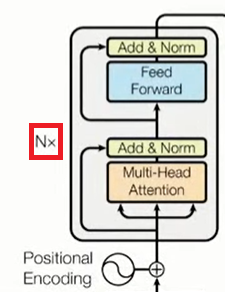

In [ ]:
# 4.1.1 EncoderLayer for one head attention Without msk
class EncoderLayerOneHeadAttention(tf.keras.layers.Layer):

  def __init__(self, **kwargs):
    super(**kwargs).__init__()
  
  def build(self, input_shape):
    self.scaledDotproductattention = ScaledDotProductAttention()
    self.norm = tf.keras.layers.LayerNormalization()
    self.dense_out = tf.keras.layers.Dense(256)
    super().build(input_shape)
  
  def call(self, x):

    # Bloc 1: Normalization(Attention(x) + x)
    attention = self.scaledDotproductattention(x) # Shape: (size_seq, size_embedding)
    post_attention = self.norm(attention + x)     # Shape: (size_seq, size_embedding)

    # Bloc 2: Normalization(FeedFarward(x) + x)
    x = self.dense_out(post_attention)            # Shape: (size_seq, size_embedding)
    enc_output = self.norm(x + post_attention)    # Shape: (size_seq, size_embedding)
    return enc_output


# Test 
batch_size, size_seq, size_embedding = None, 5, 256

input_layer = tf.keras.Input(shape=(size_seq, ))
emb_layer   = EmbeddingLayer(nb_token=size_seq)(input_layer)
attention   = EncoderLayerOneHeadAttention()(emb_layer)
model       = tf.keras.Model(input_layer, attention)

model.summary()
model(input_seq).shape

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
embedding_layer_4 (Embedding (None, 5, 256)            1280      
_________________________________________________________________
encoder_layer_one_head_atten (None, 5, 256)            263680    
Total params: 264,960
Trainable params: 264,960
Non-trainable params: 0
_________________________________________________________________


TensorShape([1, 5, 256])

In [ ]:
# 4.1.2 EncoderLayer for Multi-Head Attentions Without Mask  

class EncoderLayerWithoutMask(tf.keras.layers.Layer):

  def __init__(self, **kwargs):
    super(**kwargs).__init__()
  
  def build(self, input_shape):
    self.multi_attention = MultiHeadAttentionWithoutMask()
    self.norm = tf.keras.layers.LayerNormalization()
    self.dense_out = tf.keras.layers.Dense(256)
    super().build(input_shape)
  
  def call(self, x):

    # Bloc 1: Normalization(Attention(x) + x)
    attention = self.multi_attention(x) # Shape: (size_seq, size_embedding)
    post_attention = self.norm(attention + x)     # Shape: (size_seq, size_embedding)

    # Bloc 2: Normalization(FeedFarward(x) + x)
    x = self.dense_out(post_attention)            # Shape: (size_seq, size_embedding)
    enc_output = self.norm(x + post_attention)    # Shape: (size_seq, size_embedding)
    return enc_output


# Test 
batch_size, size_seq, size_embedding = None, 5, 256

input_layer = tf.keras.Input(shape=(size_seq, ))
emb_layer   = EmbeddingLayer(nb_token=size_seq)(input_layer)
attention   = EncoderLayerWithoutMask()(emb_layer)
model       = tf.keras.Model(input_layer, attention)

model.summary()
model(input_seq).shape

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
embedding_layer_5 (Embedding (None, 5, 256)            1280      
_________________________________________________________________
encoder_layer_without_mask ( (None, 5, 256)            329472    
Total params: 330,752
Trainable params: 330,752
Non-trainable params: 0
_________________________________________________________________


TensorShape([1, 5, 256])

In [ ]:
# 4.1.3 EncoderLayer for multiattention With Mask

class EncoderLayerWithMask(tf.keras.layers.Layer):

  def __init__(self, **kwargs):
    super(**kwargs).__init__()
  
  def build(self, input_shape):
    self.multi_attention = MultiHeadAttentionWithMask()
    self.norm = tf.keras.layers.LayerNormalization()
    self.dense_out = tf.keras.layers.Dense(256)
    super().build(input_shape)
  
  def call(self, x, mask=None):

    # Bloc 1: Normalization(Attention(x) + x)
    attention = self.multi_attention((x, x, x), mask=mask) # Shape: (size_seq, size_embedding)
    post_attention = self.norm(attention + x)     # Shape: (size_seq, size_embedding)

    # Bloc 2: Normalization(FeedFarward(x) + x)
    x = self.dense_out(post_attention)            # Shape: (size_seq, size_embedding)
    enc_output = self.norm(x + post_attention)    # Shape: (size_seq, size_embedding)
    return enc_output


# Test 
batch_size, size_seq_out, size_embedding = None, 6, 256

input_layer = tf.keras.Input(shape=(size_seq_out, ))
emb_layer   = EmbeddingLayer(nb_token=size_seq_out)(input_layer)

# Mask
mask = tf.sequence_mask(tf.range(size_seq_out) + 1, size_seq_out)
mask = tf.cast(mask, tf.float32)
mask = tf.expand_dims(mask, axis=0) # To be able to do the multiplication

print("EMB:", emb_layer.shape, "mask:", mask.shape)
attention   = EncoderLayerWithMask()(emb_layer, mask=mask)
model       = tf.keras.Model(input_layer, attention)

model.summary()
model(output_seq).shape


EMB: (None, 6, 256) mask: (1, 6, 6)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
embedding_layer_6 (Embedding (None, 6, 256)            1536      
_________________________________________________________________
encoder_layer_with_mask (Enc (None, 6, 256)            329472    
Total params: 331,008
Trainable params: 331,008
Non-trainable params: 0
_________________________________________________________________


TensorShape([1, 6, 256])

In [ ]:
# 4.2.2 Encoder for multiattention WithoutMask
class Encoder(tf.keras.layers.Layer):
    def __init__(self, nb_encoder, **kwargs):
        self.nb_encoder = nb_encoder
        super(**kwargs).__init__()

    def build(self, input_shape):
        self.encoder_layers = [EncoderLayerWithoutMask() for nb in range(self.nb_encoder)]
        super().build(input_shape)

    def call(self, x):
        # Iterate on all encoders
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
        return x

# Test 
nb_encoder = 6
batch_size, size_seq, size_embedding = None, 5, 256

# 1. Input
input_layer = tf.keras.Input(shape=(size_seq,))
print(f"input_layer.shape: {input_layer.shape} - input_seq.shape: {input_seq.shape}")

# 2. Model
emb_layer = EmbeddingLayer(nb_token=size_seq)(input_layer)
print(f"emb_layer.shape  : {emb_layer.shape}")
attention = Encoder(nb_encoder=nb_encoder)(emb_layer)
model     = tf.keras.Model(input_layer, attention)

model.summary()
model(input_seq).shape

input_layer.shape: (None, 5) - input_seq.shape: (1, 5)
emb_layer.shape  : (None, 5, 256)
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
embedding_layer_7 (Embedding (None, 5, 256)            1280      
_________________________________________________________________
encoder (Encoder)            (None, 5, 256)            1976832   
Total params: 1,978,112
Trainable params: 1,978,112
Non-trainable params: 0
_________________________________________________________________


TensorShape([1, 5, 256])

# 5. Decodeur

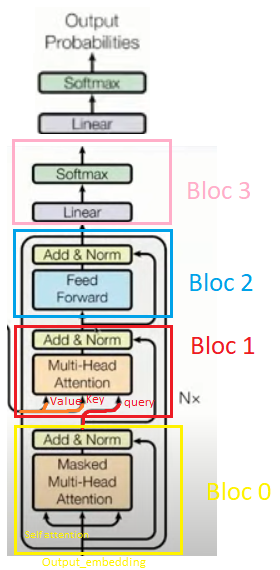

In [ ]:
# 5.1 DecoderLayer for Multi-Head Attentions with mask
class DecoderLayer(tf.keras.layers.Layer):

  def __init__(self, **kwargs):

    super(**kwargs).__init__()
  
  def build(self, input_shape):

    self.multi_head_self_attention = MultiHeadAttentionWithMask()
    self.multi_head_enc_attention  = MultiHeadAttentionWithMask()
    self.norm        = tf.keras.layers.LayerNormalization()
    self.dense_out   = tf.keras.layers.Dense(256)
    self.proj_output = tf.keras.layers.Dense(256)
    super().build(input_shape)
  
  def call(self, x):
    # output_embedding.shape: (None, 6, 256)
    # encoder_output.shape: (None, 5, 256)
    # Mask.shape: (1, 6, 6)
    encoder_output, output_embedding, mask = x

    """Bloc 0: 
    Self_Attention(output_embedding_yellow) + 
    Skip_connexion(Norm((output_embedding + self_attention))
    """
    self_attention = self.multi_head_self_attention(
        [output_embedding, output_embedding, output_embedding], mask=mask
        ) # Shape: (None, None, 256)

    post_self_att = self.norm(output_embedding + self_attention) # Shape: (None, 6, 256)
    """Bloc 1: 
    - Query comes from the decoder
    - Key and value come from the decoder
    Multi_Head_Attention(query_post_self_att, key_encoder_output, value_encoder_output) + 
    Skip_connexion(Norm((output_embedding + self_attention))
    """
    enc_attention = self.multi_head_self_attention(
        (post_self_att, encoder_output, encoder_output)
    )
    post_enc_attention = self.norm(enc_attention + post_self_att)
    """Bloc 2: 
    Linear + Skip_connexion 
    """
    proj_out   = self.proj_output(post_enc_attention)
    dec_output = self.norm(proj_out + post_enc_attention) # Shape: (None, 6, 256)

    return dec_output

In [ ]:
# 5.2 Decoder for Multi-Head Attentions with mask
class Decoder(tf.keras.layers.Layer):
    def __init__(self, nb_decoder, **kwargs):
        self.nb_decoder = nb_decoder
        super(**kwargs).__init__()

    def build(self, input_shape):
        self.decoder_layers = [DecoderLayer() for nb in range(self.nb_decoder)]

    def call(self, x):
        encoder_output, output_embedding, mask = x

        decoder_output = output_embedding
        for decoder_layer in self.decoder_layers:
            dec_output = decoder_layer([encoder_output, decoder_output, mask])
        return decoder_output

In [ ]:
# Test 
nb_encoder, nb_decoder = 6, 6
batch_size, size_seq_in, size_seq_out, size_embedding = None, 5, 6, 256

# Input
input_token  = tf.keras.Input(shape=(size_seq_in,))
output_token = tf.keras.Input(shape=(size_seq_out,))

# Positional encoding
input_pos_encoding  = EmbeddingLayer(nb_token=size_seq_in)(tf.range(size_seq_in))
output_pos_encoding = EmbeddingLayer(nb_token=size_seq_out)(tf.range(size_seq_out))

# Retrieve embedding
input_embedding  = EmbeddingLayer(nb_token=size_seq_in)(input_token)
output_embedding = EmbeddingLayer(nb_token=size_seq_out)(output_token)

# Add the positional encoding
"""
Il existe plusieurs façon de le faire
- Sinus Cosinus
- Embedding pour encoder les positions et laisser le reseau apprendre a assigner les corrects embdedding pour chaque position
"""
input_embedding = input_embedding + input_pos_encoding
output_embedding = output_embedding + output_pos_encoding

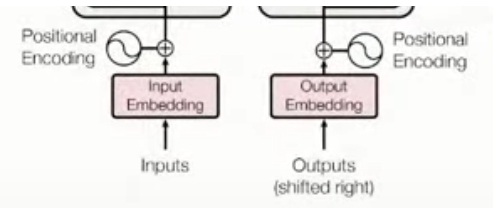

In [ ]:
# Encoder
encoder_output  = Encoder(nb_encoder=nb_encoder)(input_embedding)
print(f"input_embedding.shape: {input_embedding.shape}")
print(f"encoder_output.shape: {encoder_output.shape}")

# Mask
mask = tf.sequence_mask(tf.range(size_seq_out) + 1, size_seq_out)
mask = tf.cast(mask, tf.float32)
mask = tf.expand_dims(mask, axis=0) # To be able to do the multiplication
print(f"Mask.shape: {mask.shape}")

# Decoder

print(f"output_embedding.shape: {output_embedding.shape}")
decoder_output = Decoder(nb_decoder=nb_decoder)([encoder_output, output_embedding, mask])

# Bloc 3: Dense + softmax -> Predictions
out_pred    = tf.keras.layers.Dense(len(output_voc))(decoder_output)
predictions = tf.nn.softmax(out_pred, axis=-1)

model = tf.keras.Model(inputs=[input_token, output_token], outputs=predictions)
encoder_output = model([input_seq, output_seq])

print(f"predictions.shape: {encoder_output.shape}")

model.summary()

input_embedding.shape: (None, 5, 256)
encoder_output.shape: (None, 5, 256)
Mask.shape: (1, 6, 6)
output_embedding.shape: (None, 6, 256)
predictions.shape: (1, 6, 8)
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding_layer_44 (EmbeddingLa (None, 5, 256)       1280        input_27[0][0]                   
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
tf.__operators__.add_16 (